In [13]:
%pip install webcolors kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 MB 6.0 MB/s eta 0:00:0000:01m0:01m
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2
from math           import sin, cos
from itertools      import pairwise
from threader       import Threader
from geometry       import GHalfLine, GSegment, GPoint, list2gsegments, Angle
from geometry.utils import circle_intersection
from tlayer         import TLayer
from gcode_file     import GcodeFile
from pathlib        import Path
from util           import deep_update
from ipywidgets     import HBox, VBox

from Geometry3D import HalfLine, Segment, Point
from Geometry3D.calc import intersection

import logger, plotting, plot_styles
import plot_helpers, util
import sys
import plotly.graph_objects as go
import webcolors

from plot_helpers import quickplot
from config import get_bed_config, get_general_config, get_ring_config

#This module has settings specific to our current printer setup
try:
    import ender3v2 as ender3
except ImportError:
    import ender3
    

reload threader

In [2]:
def isec_with_halfline(halfline:GHalfLine, items, nth=0):
    return sorted(halfline.intersections(items).values(), key=halfline.point.distance)[nth]

def isec_with_angle(origin, angle, items, nth=0):
    o = GPoint(*origin)
    h = GHalfLine(o, o.moved(x=1)).rotated(angle)
    return isec_with_halfline(h, items, nth)

In [3]:
test_root = Path('./example/uist_figure/')
gcode_filename = test_root.joinpath('uist_figure.gcode')

In [4]:
gcode = GcodeFile(gcode_filename, layer_class=TLayer)
gcode.layers[0].add_geometry()
obj = gcode.layers[0].geometry.segments
off = GPoint(10.2, 10.2, .2)
thread = [GPoint(18,0) + off]
thread.append(isec_with_halfline(GHalfLine(thread[0], GPoint((17,6)) + off), obj, nth=1))
thread.append(isec_with_angle(thread[-1], Angle(degrees=150), obj, nth=3))
thread.append(isec_with_angle(thread[-1], Angle(degrees=16), obj, nth=1))
thread

[{ 28.20,  10.20,   0.20},
 { 26.54,  20.17,   0.20},
 { 10.40,  29.49,   0.20},
 { 25.43,  33.80,   0.20}]

In [5]:
logger.restart_logging()
threader = Threader(gcode, 'ender3.yaml', thread, start_anchor=thread[0])
threader.route_model()

Accordion()

Loaded general config: {'initial_thread_angle': 90, 'defaults': {'head_raise': 1, 'head_raise_speed': 200, 
'overlap_length': 2, 'move_feedrate': -1, 'extrude_multiply': -1, 'post_pause': -1}, 'anchor_fixing': 
{'head_raise': 1, 'head_raise_speed': 200, 'overlap_length': 2, 'move_feedrate': 500, 'extrude_multiply': 3, 
'post_pause': 2}, 'extruding': {'head_raise': 1, 'head_raise_speed': 200, 'overlap_length': 2, 'move_feedrate': -1,
'extrude_multiply': 1, 'post_pause': 0}, 'non_extruding': {'head_raise': 1, 'head_raise_speed': 200, 
'overlap_length': 2, 'move_feedrate': 500, 'extrude_multiply': -1, 'post_pause': -1}}

Loaded ring: {'center': {-10.10, -74.20,   0.00}, 'radius': 93, 'angle': 90.000°, 'home_angle': 90.000°, 
'min_move': 0.113°, 'feedrate': 5000, 'motor_gear_teeth': 19, 'ring_gear_teeth': 112, 
'stepper_microsteps_per_rotation': 3200, 'collision_avoid': [{'head_between': [0, 25], 'ring_between': (145.000°, 
185.000°), 'move_ring_to': 185.000°}, {'head_between': [95, 200], 'ring_between': (0.000°, 45.000°), 
'move_ring_to': 45.000°}, {'head_between': [95, 200], 'ring_between': (340.000°, 360.000°), 'move_ring_to': 
340.000°}]}

Loaded bed: {'zero': {-51.00, -65.00,   0.00}, 'size': [110, 220], 'anchor': {-72.50, -65.00,   0.00}}

Ring relative to bed zero: {'center': { 40.90,  -9.20,   0.00}, 'radius': 93, 'angle': 90.000°, 'home_angle': 
90.000°, 'min_move': 0.113°, 'feedrate': 5000, 'motor_gear_teeth': 19, 'ring_gear_teeth': 112, 
'stepper_microsteps_per_rotation': 3200, 'collision_avoid': [{'head_between': [0, 25], 'ring_between': (145.000°, 
185.000°), 'move_ring_to': 185.000°}, {'head_between': [95, 200], 'ring_between': (0.000°, 45.000°), 
'move_ring_to': 45.000°}, {'head_between': [95, 200], 'ring_between': (340.000°, 360.000°), 'move_ring_to': 
340.000°}]}

Bed now: {'zero': {  0.00,   0.00,   0.00}, 'size': [110, 220], 'anchor': {-21.50,   0.00,   0.00}}

Init: {'center': { 40.90,  -9.20,   0.00}, 'radius': 93, 'angle': 90.000°, 'home_angle': 90.000°, 'min_move': 
0.113°, 'feedrate': 5000, 'motor_gear_teeth': 19, 'ring_gear_teeth': 112, 'stepper_microsteps_per_rotation': 3200, 
'collision_avoid': [{'head_between': [0, 25], 'ring_between': (145.000°, 185.000°), 'move_ring_to': 185.000°}, 
{'head_between': [95, 200], 'ring_between': (0.000°, 45.000°), 'move_ring_to': 45.000°}, {'head_between': [95, 
200], 'ring_between': (340.000°, 360.000°), 'move_ring_to': 340.000°}]}

In [6]:
zoom_factor = 2
marker_size = 12
marker_outline_color = 'DarkSlateGray'

old_plot_styles = {
    #Thread styles
    'future_thread': {'line': dict(color='#b28600', width=2*zoom_factor, dash='dash')},
    'printed_thread':{'line': dict(color='#b28600', width=3*zoom_factor, dash=None)},
    'thread_ring':   {'line': dict(color='#f47a61', width=2*zoom_factor, dash=f'{2*zoom_factor}px,{2*zoom_factor}px')},
    
    #Printed segment styles
    'gc_segs':       {'line': dict(width=3*zoom_factor)},
    'old_segs':      {'line': dict(width=2*zoom_factor, color='LightGray')},
    'to_print':      {'line': dict(width=1*zoom_factor, color='#1192e8', dash='dot'), 'opacity': 1},
    
    #Anchor styles
    'future_anchor':   {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='white', line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'next_anchor':     {'marker': dict(symbol='circle', size=zoom_factor*marker_size/2, color='white', line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'anchor':          {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='red',   line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'original_anchor': {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='LightGray',  line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'thread_fixation': {'marker': dict(symbol='circle', size=zoom_factor*marker_size*1.5,   color='rgba(0,0,255,0.1)', line=dict(width=zoom_factor*1, color='rgba(0,0,255,0.5)'))},
}

#ca0020 - red
#f4a582 - orange
#f7f7f7 - white-ish
#92c5de - light blue
#0571b0 - dark blue

def hex2rgba(h, a):
    """#rrggbb -> (RRR, GGG, BBB, a)"""
    h = h[1:] if h.startswith('#') else h
    return f'rgba{tuple(int(h[i:i+2], 16) for i in (0, 2, 4)) + (a,)}'

colors = {
    'thread':           '#f4a582',
    'thread ring':      '#ca0020',
    'curr anchor':      '#ca0020',
    'printed filament': '#0571b0',
    'fixation':         '#0571b0',
    'to print':         '#92c5de',
    
    'ring':             '#0f71b0',
    'carrier':          '#f4a582',
    'arrow':            '#92c5de',
}

plot_styles = {
    #Thread styles
    'future_thread': {'line': dict(color=colors['thread'], width=2*zoom_factor, dash='dash')},
    'printed_thread':{'line': dict(color=colors['thread'], width=3*zoom_factor, dash=None)},
    'thread_ring':   {'line': dict(color=colors['thread ring'], width=2*zoom_factor, dash=f'{2*zoom_factor}px,{2*zoom_factor}px')},
    
    #Printed segment styles
    'gc_segs':       {'line': dict(color=colors['printed filament'],   width=3*zoom_factor)},
    'old_segs':      {'line': dict(color='LightGray', width=2*zoom_factor)},
    'to_print':      {'line': dict(color=colors['to print'],   width=1*zoom_factor, dash='dot'), 'opacity': 1},
    
    #Anchor styles
    'future_anchor':   {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='white', line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'next_anchor':     {'marker': dict(symbol='circle', size=zoom_factor*marker_size/2, color='white', line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'anchor':          {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color=colors['curr anchor'],   line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'original_anchor': {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='LightGray',  line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'thread_fixation': {'marker': dict(symbol='circle', size=zoom_factor*marker_size*1.5,   color=hex2rgba(colors['fixation'], .1), line=dict(width=zoom_factor*1, color=hex2rgba(colors['fixation'], .5)))},
}

plot_styles['next_anchor'] = deep_update(plot_styles['future_anchor'], {'marker': {'size': marker_size/2*zoom_factor}})

paper_styles = deep_update(plot_helpers.styles, plot_styles)

Preview of 14 steps for layer 0


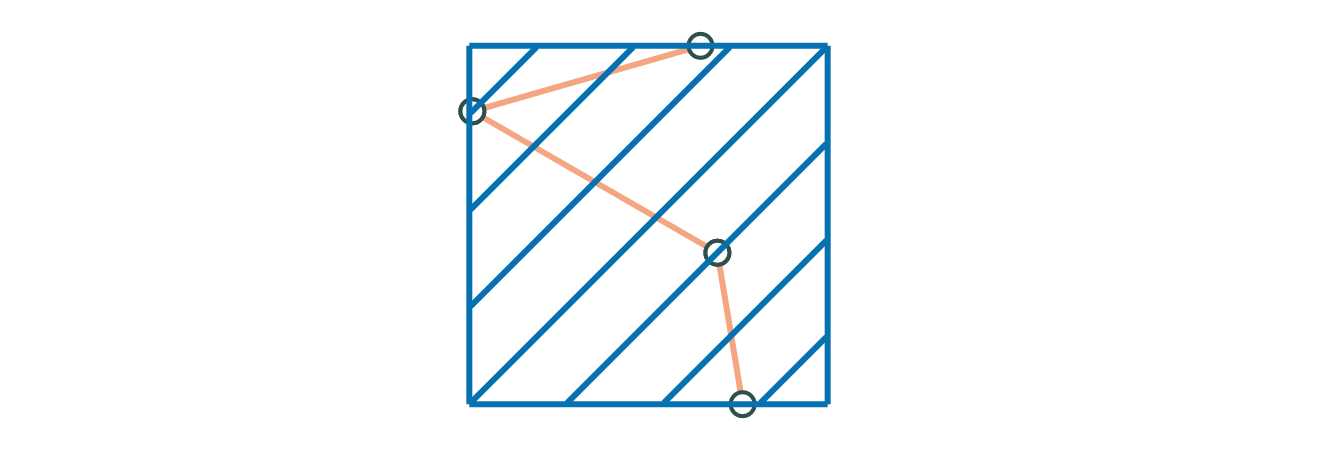

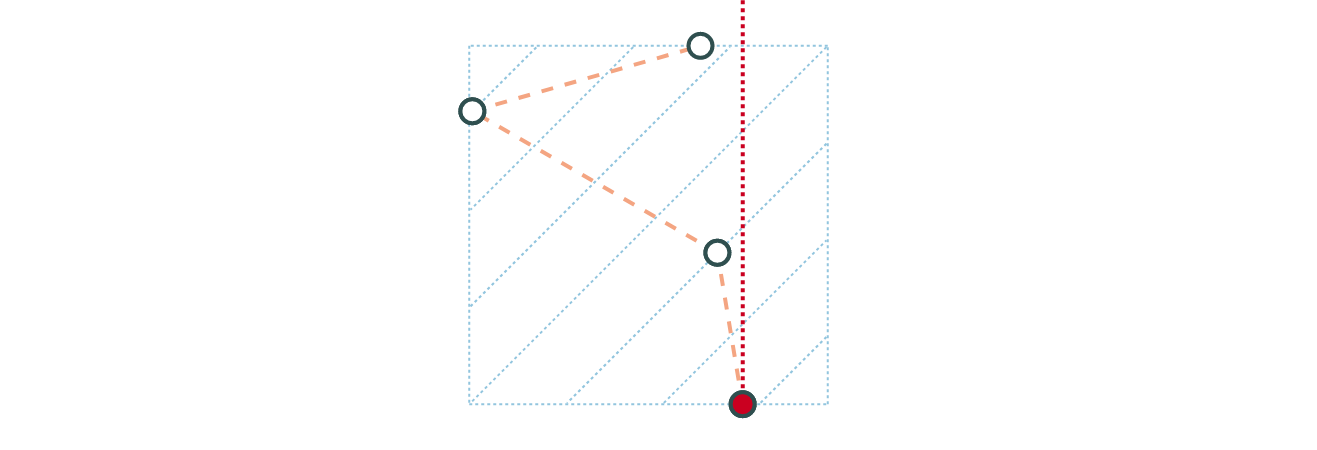

Step 0: Rotate thread at { 28.20,  10.20,   0.20} to overlap next anchor at { 26.54,  20.17,   0.20}
H({ 28.20,  10.20,   0.20}, ↗ 99.46° ( -1.66,   9.97,   0.00))


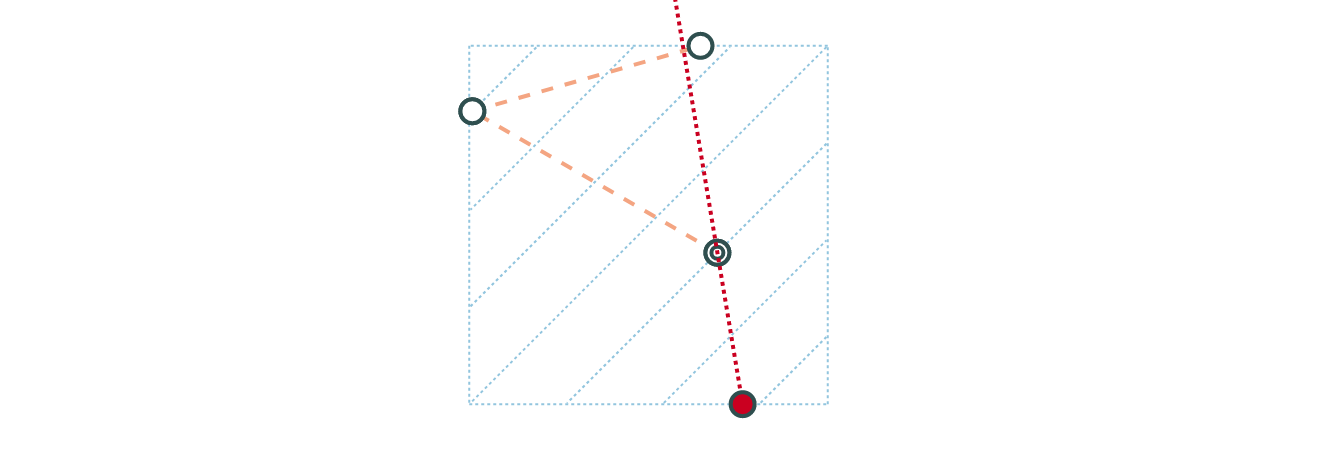

Step 1: Print 1 segment to fix anchor
H({ 26.54,  20.17,   0.20}, ↗ 99.46° ( -1.66,   9.97,   0.00))


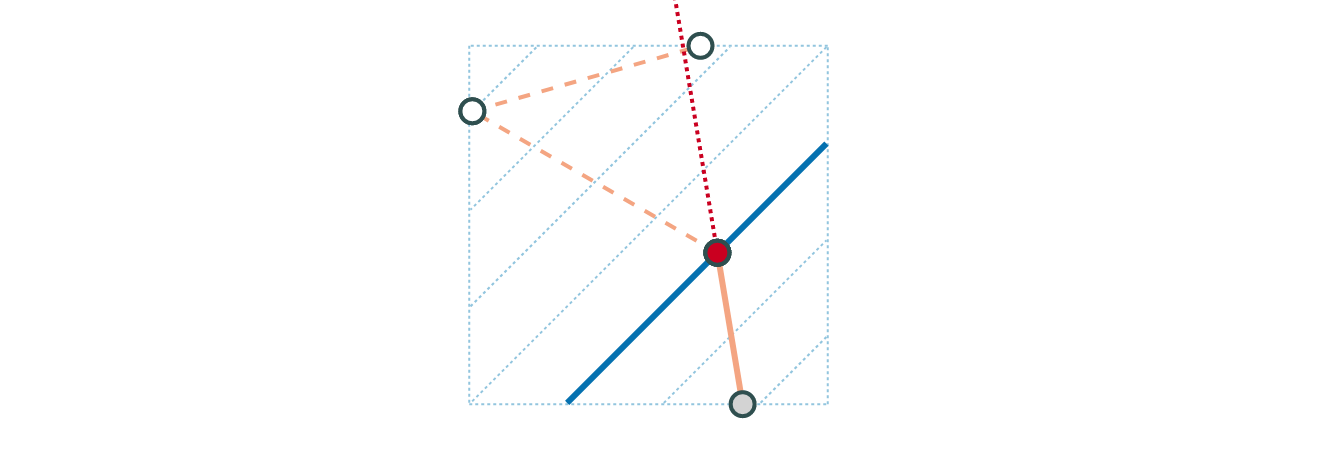

Skip 2
Step 3: Print 2 segments thread doesn't intersect
H({ 26.54,  20.17,   0.20}, ↗ 99.46° ( -1.66,   9.97,   0.00))
print_thread_isecs=[{ 27.45,  14.72,   0.20}]


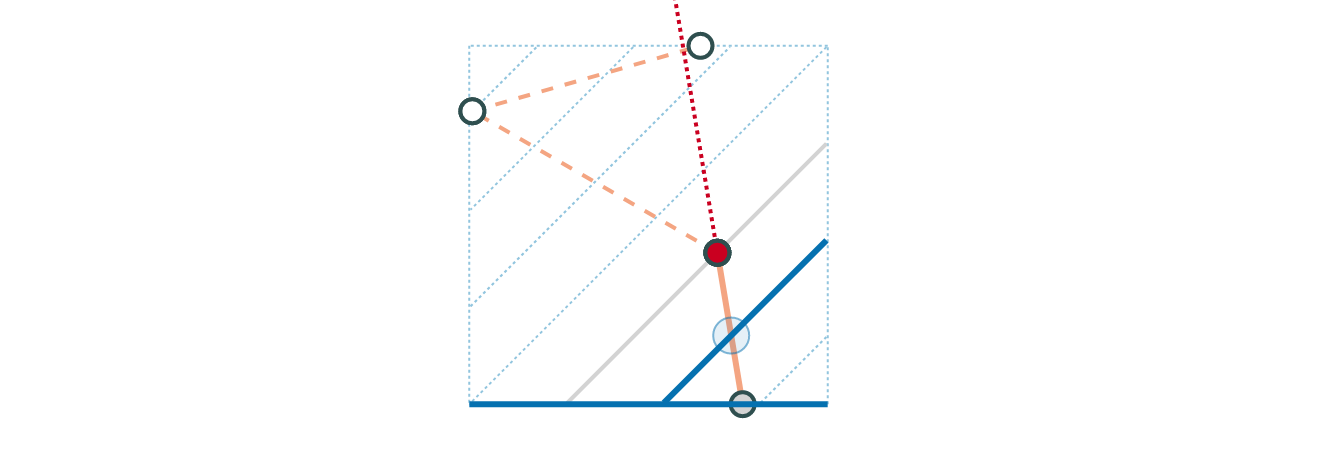

Step 4: Rotate thread at { 26.54,  20.17,   0.20} to overlap next anchor at { 10.40,  29.49,   0.20}
H({ 26.54,  20.17,   0.20}, ↗150.00° (-16.14,   9.32,   0.00))


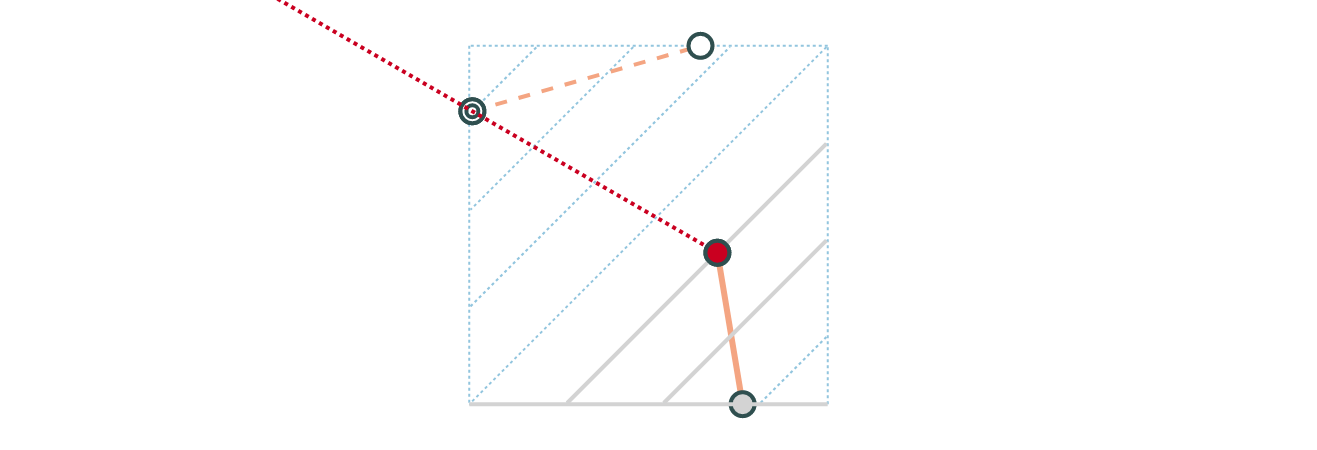

Step 5: Print 1 segment to fix anchor
H({ 10.40,  29.49,   0.20}, ↗150.00° (-16.14,   9.32,   0.00))


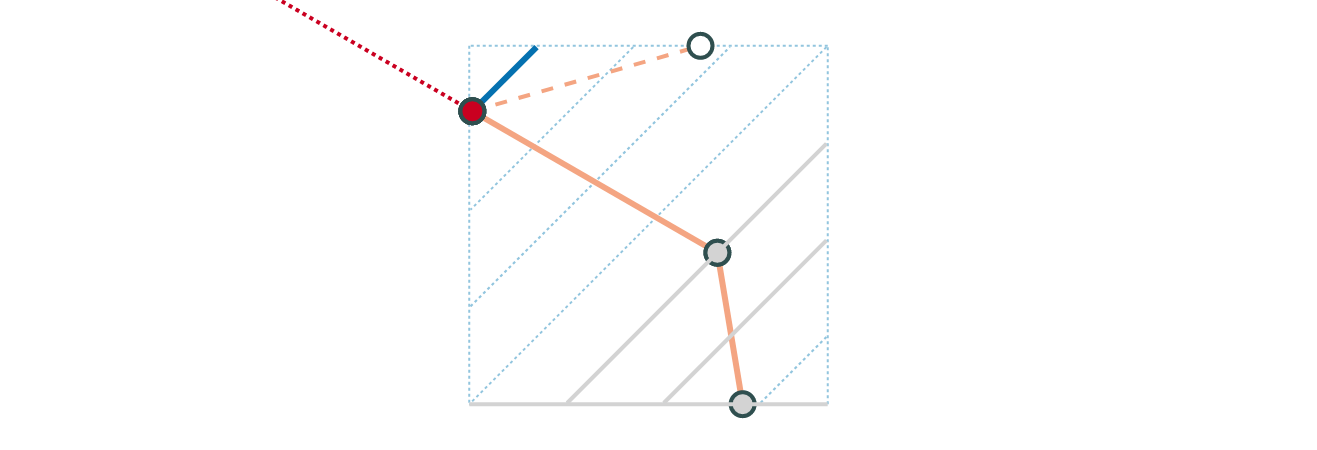

Skip 6
Step 7: Print 2 segments thread doesn't intersect
H({ 10.40,  29.49,   0.20}, ↗150.00° (-16.14,   9.32,   0.00))
print_thread_isecs=[{ 22.50,  22.50,   0.20}, { 18.47,  24.83,   0.20}]


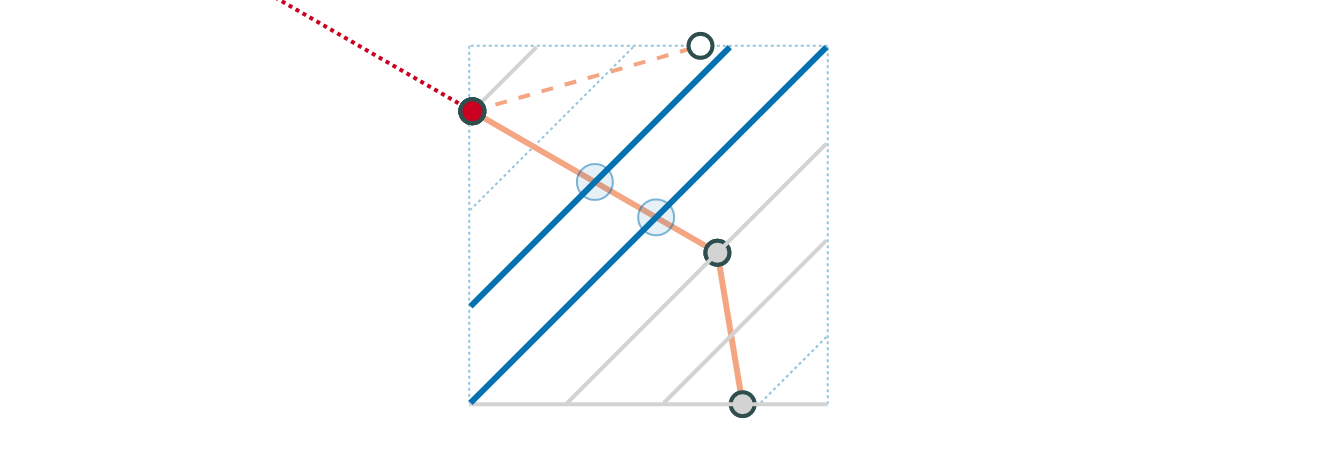

Step 8: Rotate thread at { 10.40,  29.49,   0.20} to overlap next anchor at { 25.43,  33.80,   0.20}
H({ 10.40,  29.49,   0.20}, ↗ 16.00° ( 15.03,   4.31,   0.00))


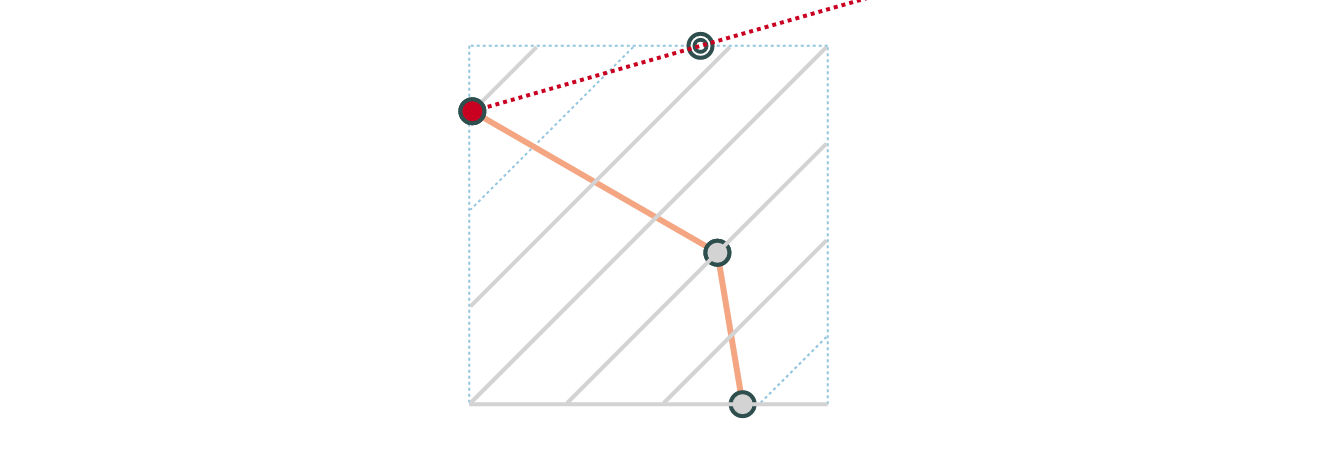

Step 9: Print 1 segment to fix anchor
H({ 25.43,  33.80,   0.20}, ↗ 16.00° ( 15.03,   4.31,   0.00))


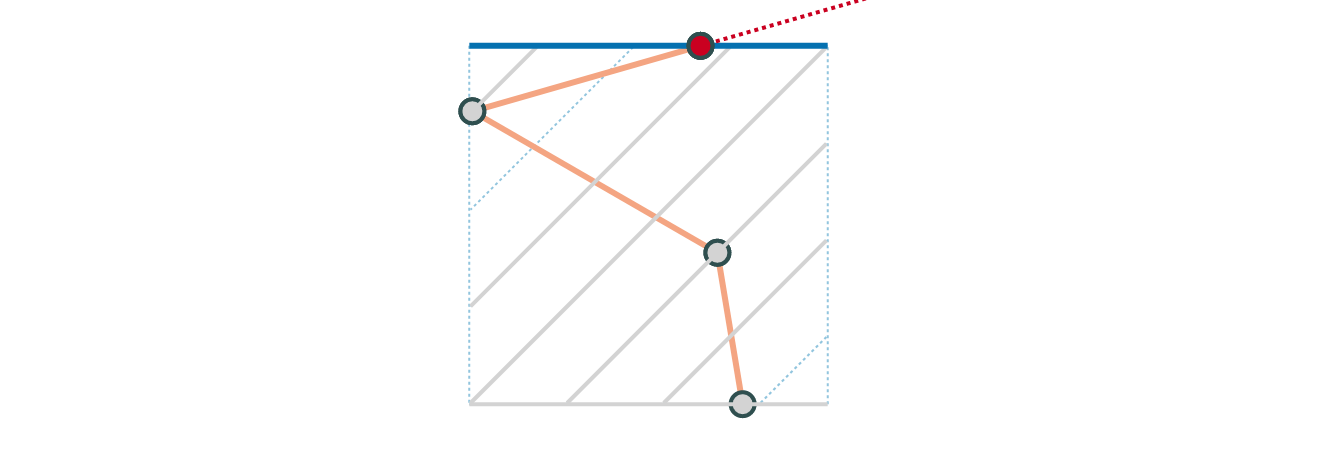

Skip 10
Step 11: Print 1 segments thread doesn't intersect
H({ 25.43,  33.80,   0.20}, ↗ 16.00° ( 15.03,   4.31,   0.00))
print_thread_isecs=[{ 14.43,  27.16,   0.20}, { 19.32,  32.05,   0.20}]


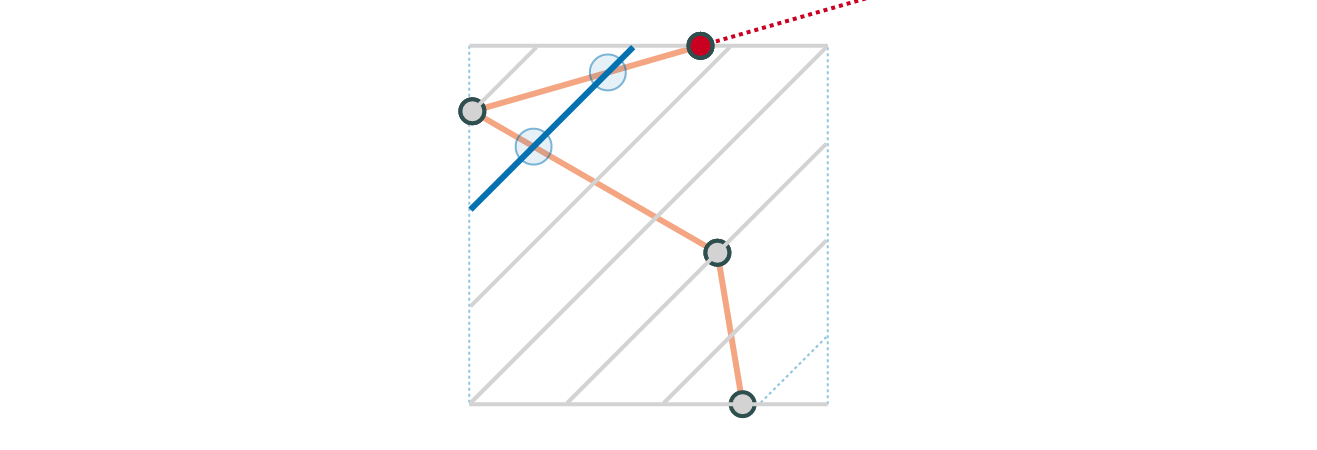

Skip 12
Step 13: Print 3 segments thread doesn't intersect
H({ 25.43,  33.80,   0.20}, ↗ 16.00° ( 15.03,   4.31,   0.00))


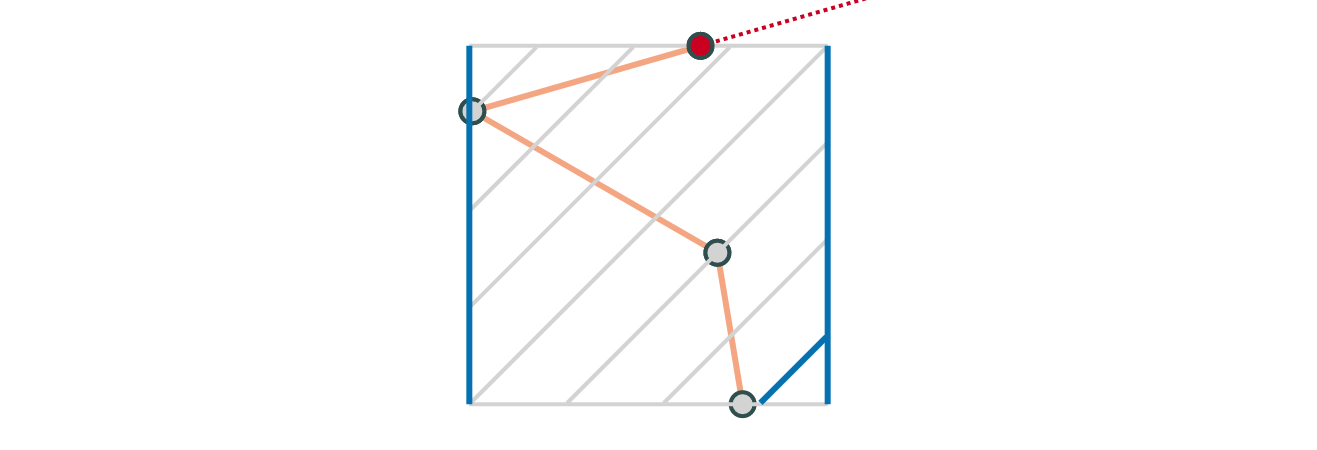

Finished routing this layer


In [7]:
test_layer = 0
figs = plotting.plot_steps(threader.layer_steps[test_layer], template='plotly_white',
    styles=paper_styles,
    show_args={
        'xaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
        'yaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
    }, #show=False
                          )#, prev_layer=gcode.layers[test_layer-1], prev_layer_only_outline=False, preview_layer=False)
#plotting.plot_test(threader.layer_steps[1])

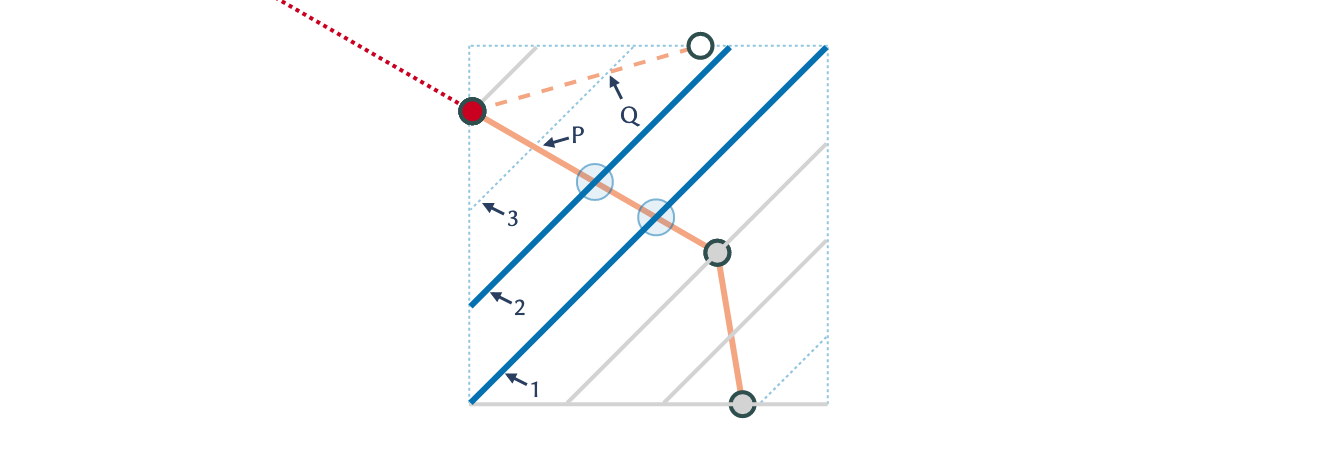

In [8]:
arrows = dict(
    arrowhead  = 2,
    arrowsize  = .75,
    arrowwidth = 3,
    font = dict(
        size=25,
        family="Linux Biolinum",
    ),
    showarrow = True,
    xshift = 4,
    yshift = -1,
    borderpad = 1,
)

fig7ann = go.Figure(figs[7])
fig7ann.layout.annotations = []
fig7ann.add_annotation(x=10.279+2, y=10.279+2, text="1", ax=30, ay=15, **arrows)
fig7ann.add_annotation(x=10.279+1, y=16.643+1, text="2", ax=30, ay=15, **arrows)
fig7ann.add_annotation(x=10.279+.5, y=23.007+.5, text="3", ax=30, ay=15, **arrows)
fig7ann.add_annotation(x=10.279+4.5, y=23.007+4.3, text="P", ax=35, ay=-10, **arrows)
fig7ann.add_annotation(x=20.991-1.8, y=33.719-1.8, text="Q", ax=20, ay=40, **arrows)
fig7ann

In [512]:
for i,fig in enumerate(figs):
    fig.write_image(f'algorithm-{i:02}.pdf')

In [10]:
fig7ann.write_image(f'algorithm-07_ann.pdf')

In [525]:
old_printer_styles = {
    'ring':          {'line': dict(width=10, color='#0E7364'), 'layer': 'below'},
    'ring_angle':    {'line': dict(width=.5, color='#aaaaaa', dash='dot')},
    'ring_center':   {'marker': dict(symbol='circle', size=5, color='DarkGray'), 'line': None},
    'bed':           {'line': dict(width=1, color='#cccccc'), 'fillcolor': '#F8F5F2', 'layer': 'below'},
    'carrier':       {'marker': dict(symbol='circle', size=10, color='#FEDE63')},
    'anchor':        deep_update(paper_styles['anchor'],        {'marker': dict(size=12, line=dict(width=2))}),
    'future_anchor': deep_update(paper_styles['future_anchor'], {'marker': dict(size=12, line=dict(width=2))}),
    'next_anchor':   deep_update(paper_styles['next_anchor'],   {'marker': dict(size= 6, line=dict(width=2))}),
}

printer_styles = {
    'ring':          {'line': dict(width=10, color=colors['ring']), 'layer': 'below'},
    'ring_angle':    {'line': dict(width=.5, color='#aaaaaa', dash='dot')},
    'ring_center':   {'marker': dict(symbol='circle', size=5, color='DarkGray'), 'line': None},
    'bed':           {'line': dict(width=1, color='#cccccc'), 'fillcolor': '#F8F5F2', 'layer': 'below'},
    'carrier':       {'marker': dict(symbol='circle', size=10, color=colors['carrier'])},
    'anchor':        deep_update(paper_styles['anchor'],        {'marker': dict(size=12, line=dict(width=2))}),
    'future_anchor': deep_update(paper_styles['future_anchor'], {'marker': dict(size=12, line=dict(width=2))}),
    'next_anchor':   deep_update(paper_styles['next_anchor'],   {'marker': dict(size= 6, line=dict(width=2))}),
    'arrow':         dict(arrowhead=2, arrowwidth=3, arrowcolor=colors['arrow'])
}

In [526]:
def draw_printer(anchor_loc=GPoint(25,25), next_anchor=None, bed_y=0, carrier_angle=0, move_ring=False, show=False, **kwargs):
    show_args = {
        'xaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
        'yaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
        'zoom_factor': 1,
    } 
    
    bed_pos = GPoint(0, bed_y)
    ang = Angle(degrees=carrier_angle)

    #Ring info
    ring_config = threader.gcode_printer.ring_config
    rcen = ring_config['center']
    rrad = ring_config['radius']

    #Carrier location
    cx = rcen.x + cos(ang) * rrad
    cy = rcen.y + sin(ang) * rrad
    ccen = GPoint(cx, cy)

    #Move the ring to keep the thread angle constant
    if move_ring:
        ccen = circle_intersection(threader.gcode_printer.ring_config['center'],
                                   threader.gcode_printer.ring_config['radius'],
                                   GSegment(anchor_loc, ccen).moved(y=-bed_y))
        
    #Anchor locations
    anchor = anchor_loc - bed_pos
    next_anchor = next_anchor - bed_pos
                                   
    #Fiber from anchor to carrier
    fiber = GSegment(anchor, ccen)

    #Create and configure the figure
    fig = go.FigureWidget()

    #Draw the "actual" bed
    sizex = sizey = 220
    bed_config = get_bed_config(threader.gcode_printer.config)
    bed_zero = GPoint(-117.5, -65, 0) - bed_config['zero']
    bed_info = dict(
                  x0=bed_zero.x,
                  y0=bed_zero.y-bed_y,
                  x1=bed_zero.x+sizex,
                  y1=bed_zero.y+sizey-bed_y,
    )
    fig.add_shape(type='rect', xref='x', yref='y', **printer_styles['bed'], **bed_info)
    
    #Stupid hack to get the figures to all be the same size so they can be cropped
    if bed_y:
        fig.add_shape(type='rect', xref='x', yref='y', **printer_styles['bed'],
                      x0=bed_info['x0'],
                      x1=bed_info['x1'],
                      y0=bed_info['y1'],
                      y1=bed_info['y1'] + bed_y)
        
    #Draw the next anchor if there is one
    if next_anchor:
        plot_helpers.plot_points(fig, next_anchor, name='next anchor', style=printer_styles['future_anchor'])
        plot_helpers.plot_points(fig, next_anchor, name='next anchor', style=printer_styles['next_anchor'])


    #Draw angle line from ring center -> carrier
    ring_seg = GSegment(rcen, ccen)
    plot_helpers.plot_segments(fig, ring_seg, name='ring angle', style=printer_styles['ring_angle'])
    
    #Annotate the center->carrier line
    seg2 = ring_seg.rotated(by=Angle(degrees=90))
    ax = seg2.line.dv.normalized()[0] * 20
    ay = seg2.line.dv.normalized()[1] * 10 * kwargs.get('car_ang_mult_y', -1)
        
    fig.add_annotation(x=(ring_seg*.25).end_point.x, y=(ring_seg*.25).end_point.y,
                       text=f'{int(ring_seg.angle().degrees)}°',
                       textangle=-ring_seg.angle().degrees,
                       arrowcolor=printer_styles['bed']['fillcolor'], 
                       font = dict(
                           size=18,
                           family="Linux Biolinum",
                           color=printer_styles['ring_angle']['line']['color'],
                       ), 
                       ax=ax,
                       ay=ay)

    #Draw ring center point
    plot_helpers.plot_points(fig, rcen, name='ring center', style=printer_styles['ring_center'])

    #Draw fiber from anchor -> carrier
    plot_helpers.plot_segments(fig, fiber, name='fiber', style=paper_styles['thread_ring'])
    
    #Annotate the fiber line
    seg2 = fiber.rotated(by=Angle(degrees=90))
    ax = seg2.line.dv.normalized()[0] * 20
    ay = seg2.line.dv.normalized()[1] * 10 * kwargs.get('fib_ang_mult_y', -1)
    fig.add_annotation(x=(fiber*.25).end_point.x, y=(fiber*.25).end_point.y,
                       text=f'{int(fiber.angle().degrees)}°',
                       textangle=-fiber.angle().degrees,
                       arrowcolor=printer_styles['bed']['fillcolor'],
                       font=dict(
                           size=18,
                           family="Linux Biolinum",
                           color=paper_styles['thread_ring']['line']['color'],
                       ),
                       ax=ax,
                       ay=ay)

    #Draw the anchor
    plot_helpers.plot_points(fig, anchor, name='anchor', style=printer_styles['anchor'])

    #Draw the ring
    plot_helpers.add_circles(fig, rcen, ring_config['radius'], name='ring', style=printer_styles['ring'])

    #Draw the carrier
    plot_helpers.plot_points(fig, ccen, name='carrier', style=printer_styles['carrier'])
    
    #Since image export doesn't work right, manually create some tick marks
    tickvals=[-100, 0]
    ticktext=['100', '0']
    if bed_y != 0:
        tickvals.append(-bed_y)
        ticktext.append(str(bed_y))
    for y,txt in zip(tickvals, ticktext):
        fig.add_annotation(x=bed_zero.x, y=y, text=txt, xshift=-5, yshift=0, ax=-20, ay=0, align='right')
        
    #Show how bed has moved
    if bed_y != 0:
        fig.add_annotation(x=bed_zero.x-8, y=-bed_y, ax=0, ay=-bed_y*1.415, yshift=4, showarrow=True, **printer_styles['arrow'])

    plot_helpers.update_fig(fig, 
                            zoom_box=((bed_info['x0']-40, rcen.y-rrad), (bed_info['x1']+30, rcen.y+rrad)),
                            template='plotly_white', **show_args)
    if show:
        fig.show()

    return fig

In [527]:
#anchor_loc = GPoint(10, 25)
anchor_loc = GPoint(-8, 35)
carrier_angle = 0
carrier_loc = threader.gcode_printer.ring_config['center'].moved(x=threader.gcode_printer.ring_config['radius'])
next_anchor = (GSegment(anchor_loc, carrier_loc) * .5).end_point
printer_figs = [
    draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y= 0, carrier_angle=carrier_angle, car_ang_mult_y=1),
    draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=60, carrier_angle=carrier_angle, car_ang_mult_y=-1),
    draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=60, carrier_angle=carrier_angle, move_ring=True, fib_ang_mult_y=-1, car_ang_mult_y=-.5),
]
#printer_figs[0].layout['xaxis']['range'] = printer_figs[1].layout['xaxis']['range'] = printer_figs[2].layout['xaxis']['range'] = [-100.5, 153.5]
#printer_figs[0].layout['yaxis']['range'] = printer_figs[1].layout['yaxis']['range']
HBox(printer_figs)

    'data': [{'marker': {'color': 'white', 'line': {'color': 'DarkSlateGray', 'w…

In [528]:
for i,fig in enumerate(printer_figs):
    fig.write_image(f'bed_move-{i}.pdf')

In [529]:
def multi_sync():
    anchor_loc = GPoint(-8, 35)
    carrier_angle = 0
    carrier_loc = threader.gcode_printer.ring_config['center'].moved(x=threader.gcode_printer.ring_config['radius'])
    next_anchor = (GSegment(anchor_loc, carrier_loc) * .5).end_point
    return [
        draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y= 0, carrier_angle=carrier_angle, car_ang_mult_y=1),
        draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=20, carrier_angle=carrier_angle, move_ring=True, fib_ang_mult_y=-1, car_ang_mult_y=1),
        draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=40, carrier_angle=carrier_angle, move_ring=True, fib_ang_mult_y=-1, car_ang_mult_y=-.5),
        draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=60, carrier_angle=carrier_angle, move_ring=True, fib_ang_mult_y=-1, car_ang_mult_y=-.5),
        draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=80, carrier_angle=carrier_angle, move_ring=True, fib_ang_mult_y=-1, car_ang_mult_y=-.5),
        draw_printer(anchor_loc=anchor_loc, next_anchor=next_anchor, bed_y=100, carrier_angle=carrier_angle, move_ring=True, fib_ang_mult_y=-1, car_ang_mult_y=-.5),
    ]
for i,fig in enumerate(multi_sync()):
    fig.write_image(f'multi_sync-{i}.pdf')

In [475]:
def layer_snaps(anchors, layer_sep=10, show=False, add_anchors=False, moved_anchors=[], surround_points=[]):
    anchors  = [GPoint(a[0], a[1]*layer_sep) for a in anchors]
    moved    = [GPoint(a[0], a[1]*layer_sep) for a in moved_anchors]
    surround = [GPoint(a[0], a[1]*layer_sep) for a in surround_points]
    
    show_args = {
        'xaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
        'yaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
        'zoom_factor': 1,
    } 
    
    fig = go.FigureWidget()
    
    #Invisibly plot any surrounding points to fix image size
    if surround:
        plot_helpers.plot_points(fig, surround, style=paper_styles['future_anchor'], marker=dict(color='white', line=dict(color='white')))
    
    #Plot horizontal lines representing layers
    layer_segs = [GSegment((0,i*layer_sep), (layer_sep*10,i*layer_sep)) for i in range(0,6)]
    #plot_helpers.plot_segments(fig, layer_segs, style=paper_styles['gc_segs'], line=dict(width=layer_sep*4))
    for seg in layer_segs:
        fig.add_shape(type='rect',
                      layer='below',
                      x0=seg.start_point.x,
                      x1=seg.end_point.x,
                      y0=seg.start_point.y,
                      y1=seg.start_point.y+layer_sep,
                      fillcolor='rgba(0, 128, 0, .5)',
                      line=dict(color='white', width=2),
                     )
    
    #Plot anchors that were moved
    if moved:
        plot_helpers.add_circles(fig, moved, radius=3,
                                 style=dict(layer='below', line=dict(color='red', dash='dot', width=2)),
                                )

    #Plot anchors
    plot_helpers.plot_points(fig,
                             anchors,
                             style=paper_styles['future_anchor'],
                             mode='markers+lines',
                             **paper_styles['printed_thread'],
                            )
    
    
    #Find and plot intersections between fiber segments and layer lines
    new_anchors = set()
    if add_anchors:
        for s,e in list(pairwise(anchors)):
            new_anchors.update(GSegment(s,e).intersections(layer_segs).values())
        new_anchors -= {None}.union(anchors)
        if new_anchors:
            plot_helpers.plot_points(fig,
                                     new_anchors,
                                     style=paper_styles['future_anchor'],
                                     mode='markers',
                                    )
            plot_helpers.plot_points(fig,
                                     new_anchors,
                                     style=paper_styles['future_anchor'],
                                     mode='markers',
                                     marker={
                                         'symbol':'cross-thin',
                                         'size':.4*paper_styles['future_anchor']['marker']['size'],
                                         'line_width': 3,
                                     },
                                    )
    
    plot_helpers.update_fig(fig, template='plotly_white', **show_args)
    
    if show:
        fig.show()
        
    return fig   

In [483]:
layer_sep = 10
anchors1 = [(10, .55), (70, 2.35), (90, 5)]
anchors2 = [(10, 1), (70, 2), (90, 5)]
seg = GSegment(anchors1[1], anchors1[2])
snap_figs = [
    layer_snaps(anchors1, layer_sep),
    layer_snaps(anchors2, layer_sep, moved_anchors=anchors1[:2]),
    layer_snaps(anchors2, layer_sep, add_anchors=True),
]
HBox(snap_figs)

    'data': [{'line': {'color': '#b28600', 'width': 6},
              'marker': …

In [484]:
for i, fig in enumerate(snap_figs):
    fig.write_image(f'layer_snap-{i}.pdf')